# LangGraph Multi-Agent Sandbox

This notebook provides a testing environment for the Simplify Agent, which uses LangGraph to create a multi-step workflow for simplifying complex topics.

**Architecture Overview:**
- **State Management**: Defines the graph state and structured output schema
- **Model Configuration**: Sets up the LLM with structured output binding
- **Agent Graph**: Builds the LangGraph workflow with nodes and edges
- **Execution**: Runs the agent with test topics

## 1. Configuration & Environment Setup

Load environment variables and configure the OpenAI API key and model settings.

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LLM_MODEL = "gpt-4o-mini"  # Using a valid model

# Verify API key is set
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in environment variables")

print(f"✓ Configuration loaded")
print(f"✓ Model: {LLM_MODEL}")

## 2. State Management & Schema Definition

Define the Pydantic schema for structured output and the graph state that flows through the agent.

In [ ]:
from typing import TypedDict, Optional
from pydantic import BaseModel, Field

# --- Structured Output Schema ---
class TopicSummary(BaseModel):
    """
    Schema for the final, structured output of the agent.
    This ensures the LLM's response is easily parsable and high-quality.
    """
    topic: str = Field(description="The original topic provided by the user.")
    simplified_text: str = Field(
        description="A clear, simple explanation of the topic, suitable for a 10-year-old."
    )
    analogy: str = Field(
        description="A simple, relatable analogy to explain the core concept."
    )
    example: str = Field(
        description="A real-world or fictional example that illustrates the topic."
    )

# --- Graph State ---
class GraphState(TypedDict):
    """
    Represents the state of the graph's execution.
    Data flow across nodes is managed by updating this dictionary.
    """
    # The complex topic provided by the user
    user_topic: str
    # The final, structured output from the LLM
    final_summary: Optional[TopicSummary]

print("✓ State classes defined")
print(f"✓ TopicSummary fields: {list(TopicSummary.model_fields.keys())}")

## 3. Model & Prompt Configuration

Initialize the LLM with structured output binding and define the prompt template.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def get_llm_with_schema():
    """
    Initializes the LLM and binds it to the TopicSummary Pydantic schema
    to ensure the output is structured JSON.
    """
    # Initialize the LLM client
    llm = ChatOpenAI(
        model=LLM_MODEL,
        api_key=OPENAI_API_KEY,
        temperature=0.2  # Slight temperature for creative parts like analogy/example
    )

    # Bind the Pydantic schema to the LLM
    # This instructs the model to generate a JSON object matching the schema
    llm_with_schema = llm.with_structured_output(TopicSummary)
    return llm_with_schema

def get_summary_prompt():
    """
    Defines the system prompt to guide the LLM's persona and task.
    """
    system_prompt = (
        "You are an expert science communicator and educator. Your goal is to "
        "take a complex topic and explain it in a clear, highly structured, "
        "and engaging manner. You must output a JSON object that strictly "
        "adheres to the provided schema. Do not output any text other than the JSON."
    )
    
    # Placeholder for the user's input topic
    human_template = "Topic to explain: {user_topic}"

    return ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_template)
    ])

# Initialize
llm_with_schema = get_llm_with_schema()
summary_prompt = get_summary_prompt()

print("✓ LLM initialized with structured output")
print("✓ Prompt template created")

## 4. Graph Nodes & Edge Logic

Define the nodes (processing steps) and edge logic (routing decisions) for the LangGraph workflow.

In [ ]:
from langchain_core.exceptions import OutputParserException

# --- Graph Nodes ---

def generate_summary_node(state: GraphState) -> dict:
    """
    Calls the LLM with the structured output schema to generate the summary.
    This node attempts to produce the final, structured output.
    """
    print(f"--- Running Node: Generate Summary for '{state['user_topic']}' ---")
    
    # The state is used as the input variables for the prompt
    chain = summary_prompt | llm_with_schema
    
    try:
        # Invoke the chain, which forces structured JSON output
        result: TopicSummary = chain.invoke(state)
        print("Summary generated successfully.")
        
        # Update the state with the final structured result
        return {"final_summary": result}
        
    except OutputParserException as e:
        # If the LLM fails to produce valid JSON, handle the error
        print(f"Error: OutputParserException encountered: {e}")
        # Optionally, you could add logic here to re-prompt the LLM
        # For this simple example, we will stop and report the error.
        return {"final_summary": None}


# --- Graph Edges (Router) ---

def decide_to_end(state: GraphState) -> str:
    """
    A router function that determines the next step.
    Since this is a simple, single-step agent, it always proceeds to END.
    """
    print("--- Running Router: Decide to End ---")
    
    if state.get("final_summary"):
        # If we have a summary, we are done
        return "end"
    else:
        # If the summary failed to generate (e.g., due to parsing error), we also stop
        return "end"

print("✓ Graph nodes and edge logic defined")

## 5. Build the LangGraph Workflow

Assemble all components into a compiled LangGraph application.

In [ ]:
from langgraph.graph import StateGraph, END

def build_agent_graph():
    """
    Assembles the LangGraph workflow. 
    """
    print("--- Building LangGraph Agent ---")
    
    # 1. Define the graph state
    workflow = StateGraph(GraphState)

    # 2. Add nodes
    # The main node is the only step that generates content
    workflow.add_node("summary_generator", generate_summary_node)

    # 3. Set the entry point (first node to run)
    workflow.set_entry_point("summary_generator")

    # 4. Add the edge to the router
    # After the summary is generated, we call the router to decide the next step
    workflow.add_conditional_edges(
        "summary_generator",
        decide_to_end,
        {
            "end": END,  # If the router returns "end", stop the graph
        }
    )

    # 5. Compile the graph into a runnable application
    app = workflow.compile()
    print("--- LangGraph Agent Compiled ---")
    return app

# Compile the final agent application
agent_app = build_agent_graph()

print("✓ Agent graph compiled and ready")

## 6. Visualize the Graph (Optional)

Display the graph structure using Mermaid or ASCII representation.

In [ ]:
# Try to visualize the graph
try:
    from IPython.display import Image, display
    display(Image(agent_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph visualization: {e}")
    print("\nGraph structure (text):")
    print(agent_app.get_graph())

## 7. Test Execution - Simple Topic

Run the agent with a simple test topic to verify the workflow.

In [ ]:
def run_agent(topic: str):
    """
    Runs the compiled LangGraph agent with a specific topic.
    """
    print(f"\n--- Starting Agent for Topic: '{topic}' ---")

    # The initial state contains only the user's topic
    initial_state: GraphState = {"user_topic": topic, "final_summary": None}

    # Invoke the agent
    final_state: GraphState = agent_app.invoke(initial_state)

    # --- Print Final Output ---
    print("\n" + "="*50)
    print("--- FINAL RESULT ---")
    
    summary: Optional[TopicSummary] = final_state.get("final_summary")
    
    if summary:
        print(f"Topic: {summary.topic}")
        print("\n--- Simplified Text ---")
        print(summary.simplified_text)
        print("\n--- Analogy ---")
        print(summary.analogy)
        print("\n--- Example ---")
        print(summary.example)
    else:
        print("Agent failed to produce a structured summary. Check logs for errors.")

    print("="*50)
    
    return summary

# Test with a simple topic
test_topic_1 = "Photosynthesis"
result_1 = run_agent(test_topic_1)

## 8. Human-in-the-Loop Feedback System

This section implements an interactive feedback loop where you can:
- Review generated explanations
- Approve with "yes" or request regeneration with "regenerate"
- Track conversation history across attempts
- See improvements with each iteration

### 8.1 Enhanced State with Conversation History

Extend the graph state to track feedback and previous attempts.

In [13]:
from typing import TypedDict, Optional, List, Dict, Any

# Enhanced state for feedback loop
class FeedbackGraphState(TypedDict):
    """
    Extended state that includes conversation history and feedback.
    """
    # Original fields
    user_topic: str
    final_summary: Optional[TopicSummary]
    
    # New fields for feedback loop
    conversation_history: List[Dict[str, Any]]  # List of previous attempts
    feedback: Optional[str]  # "yes" or "regenerate"
    attempt_count: int  # Current attempt number
    max_attempts: int  # Maximum regeneration attempts
    user_notes: Optional[str]  # Optional feedback on what to improve

print("✓ FeedbackGraphState defined")
print("✓ New fields: conversation_history, feedback, attempt_count, max_attempts, user_notes")

✓ FeedbackGraphState defined
✓ New fields: conversation_history, feedback, attempt_count, max_attempts, user_notes


### 8.2 Graph Nodes with Feedback Logic

Define nodes that handle generation with context and human feedback collection.

In [14]:
def generate_summary_with_history_node(state: FeedbackGraphState) -> dict:
    """
    Generates a summary with context from previous attempts.
    If this is a regeneration, the prompt includes feedback from previous attempts.
    """
    attempt_num = state['attempt_count'] + 1
    print(f"\n--- Attempt #{attempt_num}: Generating Summary for '{state['user_topic']}' ---")
    
    # Build the prompt based on whether this is a regeneration
    if state['conversation_history']:
        # This is a regeneration - include context from previous attempts
        previous_attempts = state['conversation_history']
        
        # Create an enhanced prompt with context
        context_info = f"\n\nPREVIOUS ATTEMPTS ({len(previous_attempts)}):" 
        for i, attempt in enumerate(previous_attempts, 1):
            context_info += f"\n\nAttempt {i}:"
            context_info += f"\n- Simplified: {attempt['summary'].simplified_text[:100]}..."
            context_info += f"\n- Analogy: {attempt['summary'].analogy[:100]}..."
        
        context_info += "\n\nPlease generate a NEW explanation that improves upon the previous attempts. "
        context_info += "Use different analogies, examples, and explanations. Make it more engaging and clearer."
        
        # Enhanced prompt for regeneration
        from langchain_core.prompts import ChatPromptTemplate
        enhanced_prompt = ChatPromptTemplate.from_messages([
            ("system", (
                "You are an expert science communicator. The user was not satisfied with previous explanations. "
                "Generate a BETTER explanation with fresh perspectives, different analogies, and clearer examples. "
                "Output only valid JSON matching the schema."
            )),
            ("human", "Topic: {user_topic}" + context_info)
        ])
        
        chain = enhanced_prompt | llm_with_schema
    else:
        # First attempt - use standard prompt
        chain = summary_prompt | llm_with_schema
    
    try:
        # Generate the summary
        result: TopicSummary = chain.invoke(state)
        print(f"✓ Summary generated successfully (Attempt #{attempt_num})")
        
        # Add to conversation history
        new_history = state['conversation_history'].copy()
        new_history.append({
            'attempt': attempt_num,
            'summary': result,
            'feedback': None  # Will be filled in by human feedback node
        })
        
        return {
            "final_summary": result,
            "conversation_history": new_history,
            "attempt_count": attempt_num
        }
        
    except Exception as e:
        print(f"❌ Error generating summary: {e}")
        return {"final_summary": None}


def human_feedback_node(state: FeedbackGraphState) -> dict:
    """
    Collects human feedback on the generated summary.
    Asks the user to approve (yes) or request regeneration (regenerate).
    """
    print("\n" + "="*60)
    print("📋 GENERATED EXPLANATION")
    print("="*60)
    
    summary = state['final_summary']
    if summary:
        print(f"\n🎯 Topic: {summary.topic}")
        print(f"\n📝 Simplified Explanation:\n{summary.simplified_text}")
        print(f"\n🔄 Analogy:\n{summary.analogy}")
        print(f"\n💡 Example:\n{summary.example}")
    else:
        print("\n❌ No summary was generated.")
        return {"feedback": "end"}
    
    print("\n" + "="*60)
    print(f"Attempt {state['attempt_count']} of {state['max_attempts']}")
    print("="*60)
    
    # Get user feedback
    while True:
        user_input = input("\n👉 Enter 'yes' to approve or 'regenerate' to try again: ").strip().lower()
        
        if user_input in ['yes', 'y']:
            print("\n✅ Explanation approved!")
            # Update the last history entry with feedback
            updated_history = state['conversation_history'].copy()
            if updated_history:
                updated_history[-1]['feedback'] = 'approved'
            return {
                "feedback": "yes",
                "conversation_history": updated_history
            }
        
        elif user_input in ['regenerate', 'r', 'no', 'n']:
            # Optional: ask what to improve
            notes = input("\n💭 (Optional) What should be improved? Press Enter to skip: ").strip()
            
            print("\n🔄 Regenerating with improvements...")
            # Update the last history entry with feedback
            updated_history = state['conversation_history'].copy()
            if updated_history:
                updated_history[-1]['feedback'] = 'regenerate'
                if notes:
                    updated_history[-1]['user_notes'] = notes
            
            return {
                "feedback": "regenerate",
                "user_notes": notes if notes else None,
                "conversation_history": updated_history
            }
        
        else:
            print("❌ Invalid input. Please enter 'yes' or 'regenerate'.")

print("✓ Feedback nodes defined")

✓ Feedback nodes defined


### 8.3 Routing Logic

Define how the graph routes based on user feedback.

In [15]:
def route_after_feedback(state: FeedbackGraphState) -> str:
    """
    Routes the graph based on user feedback.
    - 'yes' → END (user approved)
    - 'regenerate' → generate_summary (try again)
    - Check max attempts to prevent infinite loops
    """
    feedback = state.get('feedback')
    attempt_count = state.get('attempt_count', 0)
    max_attempts = state.get('max_attempts', 3)
    
    print(f"\n--- Router: Processing feedback '{feedback}' (Attempt {attempt_count}/{max_attempts}) ---")
    
    # If user approved, end the workflow
    if feedback == 'yes':
        print("→ Routing to END (approved)")
        return "end"
    
    # If user wants to regenerate
    elif feedback == 'regenerate':
        # Check if we've hit max attempts
        if attempt_count >= max_attempts:
            print(f"⚠️  Maximum attempts ({max_attempts}) reached. Ending workflow.")
            return "end"
        else:
            print("→ Routing back to GENERATE (regenerate)")
            return "regenerate"
    
    # Default: end
    else:
        print("→ Routing to END (default)")
        return "end"

print("✓ Routing logic defined")

✓ Routing logic defined


### 8.4 Build the Feedback Loop Graph

Assemble the graph with feedback loop capability.

In [16]:
from langgraph.graph import StateGraph, END

def build_feedback_agent_graph():
    """
    Builds a LangGraph workflow with human-in-the-loop feedback.
    """
    print("\n--- Building Feedback Loop Agent ---")
    
    # 1. Create the graph with FeedbackGraphState
    workflow = StateGraph(FeedbackGraphState)
    
    # 2. Add nodes
    workflow.add_node("generate_summary", generate_summary_with_history_node)
    workflow.add_node("human_feedback", human_feedback_node)
    
    # 3. Set entry point
    workflow.set_entry_point("generate_summary")
    
    # 4. Add edges
    # After generation, always go to human feedback
    workflow.add_edge("generate_summary", "human_feedback")
    
    # After feedback, route based on user input
    workflow.add_conditional_edges(
        "human_feedback",
        route_after_feedback,
        {
            "end": END,
            "regenerate": "generate_summary"  # Loop back!
        }
    )
    
    # 5. Compile
    app = workflow.compile()
    print("✓ Feedback Loop Agent compiled")
    
    return app

# Build the feedback agent
feedback_agent = build_feedback_agent_graph()

print("\n✅ Feedback agent ready to use!")


--- Building Feedback Loop Agent ---
✓ Feedback Loop Agent compiled

✅ Feedback agent ready to use!


### 8.5 Visualize the Feedback Loop

See the graph structure with the feedback loop.

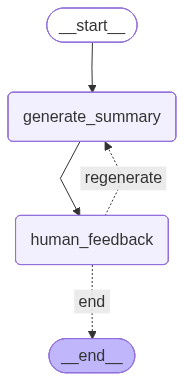

In [17]:
# Visualize the feedback graph
try:
    from IPython.display import Image, display
    display(Image(feedback_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(feedback_agent.get_graph())

### 8.6 Run the Feedback Loop Agent

Test the agent with human-in-the-loop feedback.

In [18]:
def run_agent_with_feedback(topic: str, max_attempts: int = 3):
    """
    Runs the feedback loop agent with a given topic.
    
    Args:
        topic: The complex topic to simplify
        max_attempts: Maximum number of regeneration attempts (default: 3)
    """
    print(f"\n{'='*70}")
    print(f"🚀 STARTING FEEDBACK LOOP AGENT")
    print(f"{'='*70}")
    print(f"Topic: {topic}")
    print(f"Max Attempts: {max_attempts}")
    print(f"{'='*70}\n")
    
    # Initialize state
    initial_state: FeedbackGraphState = {
        "user_topic": topic,
        "final_summary": None,
        "conversation_history": [],
        "feedback": None,
        "attempt_count": 0,
        "max_attempts": max_attempts,
        "user_notes": None
    }
    
    # Run the agent
    final_state: FeedbackGraphState = feedback_agent.invoke(initial_state)
    
    # Display final results
    print("\n\n" + "="*70)
    print("📊 FINAL RESULTS")
    print("="*70)
    
    print(f"\n✓ Total Attempts: {final_state['attempt_count']}")
    print(f"✓ Final Decision: {final_state.get('feedback', 'N/A')}")
    
    # Show conversation history
    if final_state['conversation_history']:
        print(f"\n📜 CONVERSATION HISTORY:\n")
        for entry in final_state['conversation_history']:
            print(f"  Attempt {entry['attempt']}:")
            print(f"    Feedback: {entry.get('feedback', 'N/A')}")
            if entry.get('user_notes'):
                print(f"    Notes: {entry['user_notes']}")
            print()
    
    # Show final approved summary
    if final_state.get('final_summary'):
        print("\n" + "="*70)
        print("✅ APPROVED EXPLANATION")
        print("="*70)
        summary = final_state['final_summary']
        print(f"\n🎯 Topic: {summary.topic}")
        print(f"\n📝 Simplified:\n{summary.simplified_text}")
        print(f"\n🔄 Analogy:\n{summary.analogy}")
        print(f"\n💡 Example:\n{summary.example}")
    
    print("\n" + "="*70)
    
    return final_state

print("✓ Interactive testing function ready")
print("\n💡 Usage: run_agent_with_feedback('Your Topic Here', max_attempts=3)")

✓ Interactive testing function ready

💡 Usage: run_agent_with_feedback('Your Topic Here', max_attempts=3)


### 8.7 Example: Test with a Topic

Try the feedback loop! You'll be prompted to approve or regenerate.

In [20]:
# Test the feedback loop
result = run_agent_with_feedback("BaseModel in LLM", max_attempts=3)


🚀 STARTING FEEDBACK LOOP AGENT
Topic: BaseModel in LLM
Max Attempts: 3


--- Attempt #1: Generating Summary for 'BaseModel in LLM' ---
✓ Summary generated successfully (Attempt #1)

📋 GENERATED EXPLANATION

🎯 Topic: BaseModel in LLM

📝 Simplified Explanation:
A BaseModel in a Large Language Model (LLM) is like the foundation of a building. It provides the basic structure and rules that help the model understand and generate language. Just like a building needs a strong base to support everything above it, an LLM needs a good BaseModel to work well.

🔄 Analogy:
Think of the BaseModel as the recipe for a cake. The recipe gives you the basic instructions and ingredients you need to bake the cake. Without it, you wouldn't know how to mix the ingredients or how long to bake it. Similarly, the BaseModel provides the essential guidelines for the LLM to understand and create text.

💡 Example:
Imagine a BaseModel that has learned from a huge collection of books and articles. When you ask it to